# STOCK PREDICTION

### performed by- Gurkirat kaur

#### Using Netflix Stock Dataset and predicting the price using LSTM

## Importing required libraries

In [1]:
import sys

In [3]:
!conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gaguj\Desktop\codsoft\env

  added / updated specs:
    - tensorflow


The following NEW packages will be INSTALLED:

  _tflow_select      pkgs/main/win-64::_tflow_select-2.3.0-mkl 
  abseil-cpp         pkgs/main/win-64::abseil-cpp-20211102.0-hd77b12b_0 
  absl-py            pkgs/main/win-64::absl-py-1.4.0-py310haa95532_0 
  aiohttp            pkgs/main/win-64::aiohttp-3.8.5-py310h2bbff1b_0 
  aiosignal          pkgs/main/noarch::aiosignal-1.2.0-pyhd3eb1b0_0 
  astunparse         pkgs/main/noarch::astunparse-1.6.3-py_0 
  async-timeout      pkgs/main/win-64::async-timeout-4.0.2-py310haa95532_0 
  blinker            pkgs/main/win-64::blinker-1.6.2-py



==> WARNING: A newer version of conda exists. <==
  current version: 23.5.2
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0




In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
nflx = pd.read_csv("NFLX.csv")

## Gathering some info about data

In [6]:
nflx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [7]:
nflx.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5039,2022-05-27,193.190002,195.250000,190.369995,195.190002,195.190002,8586000
5040,2022-05-31,196.179993,199.949997,190.800003,197.440002,197.440002,11398500
5041,2022-06-01,198.699997,202.740005,191.660004,192.910004,192.910004,8416200
5042,2022-06-02,192.020004,205.470001,191.720001,205.089996,205.089996,9623100
5043,2022-06-03,200.139999,202.949997,198.050003,198.979996,198.979996,7181700


In [8]:
nflx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [9]:
nflx.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
nflx1 = nflx.reset_index()["Close"]
nflx1.shape

(5044,)

In [11]:
nflx1

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
5039    195.190002
5040    197.440002
5041    192.910004
5042    205.089996
5043    198.979996
Name: Close, Length: 5044, dtype: float64

## Preprocessing the data

In [12]:
## Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
nflx1=scaler.fit_transform(np.array(nflx1).reshape(-1,1))

In [13]:
nflx1

array([[0.00119131],
       [0.00121094],
       [0.00113448],
       ...,
       [0.2785077 ],
       [0.29612623],
       [0.28728803]])

#### Splitting dataset into train and test

In [14]:
training_size = int(len(nflx1)*0.70)
test_size = len(nflx1)-training_size
train_data, test_data = nflx1[0:training_size,:], nflx1[training_size:len(nflx1),:1]

In [15]:
training_size, test_size

(3530, 1514)

#### Converting an array into dataset matrix

In [16]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ### i=0, 0,1,2,3----99
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#### Reshape into X = t, t+1, t+2, t+3 and t+4

In [17]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [18]:
x_train.shape, y_train.shape

((3429, 100), (3429,))

#### Reshape input to be [samples, time steps, features] required for LSTM

In [19]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Creating  Stacked LSTM Model

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
54/54 [==============================] - 57s 675ms/step - loss: 3.4007e-04 - val_loss: 0.0023
Epoch 2/100
54/54 [==============================] - 35s 647ms/step - loss: 2.4002e-05 - val_loss: 0.0035
Epoch 3/100
54/54 [==============================] - 35s 648ms/step - loss: 2.1725e-05 - val_loss: 0.0039
Epoch 4/100
54/54 [==============================] - 35s 641ms/step - loss: 2.1675e-05 - val_loss: 0.0038
Epoch 5/100
54/54 [==============================] - 35s 644ms/step - loss: 2.0217e-05 - val_loss: 0.0067
Epoch 6/100
54/54 [==============================] - 34s 626ms/step - loss: 2.1200e-05 - val_loss: 0.0063
Epoch 7/100
54/54 [==============================] - 34s 631ms/step - loss: 1.8233e-05 - val_loss: 0.0035
Epoch 8/100
54/54 [==============================] - 34s 632ms/step - loss: 1.9784e-05 - val_loss: 0.0053
Epoch 9/100
54/54 [==============================] - 34s 635ms/step - loss: 1.7432e-05 - val_loss: 0.0041
Epoch 10/100
54/54 [==========================

54/54 [==============================] - 19s 347ms/step - loss: 4.2672e-06 - val_loss: 3.3399e-04
Epoch 78/100
54/54 [==============================] - 19s 353ms/step - loss: 4.4320e-06 - val_loss: 8.6413e-04
Epoch 79/100
54/54 [==============================] - 19s 348ms/step - loss: 4.3699e-06 - val_loss: 3.0014e-04
Epoch 80/100
54/54 [==============================] - 19s 346ms/step - loss: 4.7375e-06 - val_loss: 6.8337e-04
Epoch 81/100
54/54 [==============================] - 19s 354ms/step - loss: 4.1496e-06 - val_loss: 8.0531e-04
Epoch 82/100
54/54 [==============================] - 19s 349ms/step - loss: 3.7477e-06 - val_loss: 4.0167e-04
Epoch 83/100
54/54 [==============================] - 19s 346ms/step - loss: 3.5917e-06 - val_loss: 0.0011
Epoch 84/100
54/54 [==============================] - 19s 345ms/step - loss: 4.4711e-06 - val_loss: 5.6307e-04
Epoch 85/100
54/54 [==============================] - 19s 349ms/step - loss: 3.6467e-06 - val_loss: 9.4747e-04
Epoch 86/100
54/54

In [23]:
tf.__version__

'2.10.0'

#### Making predictions and checking performance metrics

In [24]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

#### Transforming to original form

In [25]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

#### Calculating RMSE performance metrices

In [26]:
math.sqrt(mean_squared_error(y_train, train_predict))

37.66528905367692

In [27]:
math.sqrt(mean_squared_error(y_test, test_predict))

371.98935045866006

### Plotting the Graph

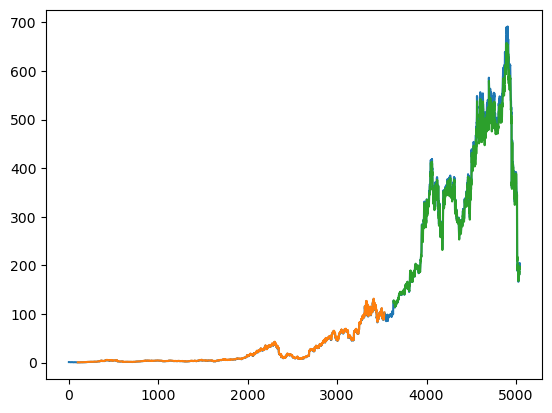

In [28]:
look_back=100
trainPredictPlot = np.empty_like(nflx1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(nflx1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(nflx1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(nflx1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

1514

In [30]:
x_input = test_data[1414:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.781793383700906,
 0.7765569216426708,
 0.7504907968107748,
 0.7598786588751534,
 0.7383400436278778,
 0.7456594006503339,
 0.7346514500229846,
 0.5744500130978235,
 0.559478583451015,
 0.5294923735762403,
 0.5197717973564795,
 0.5588276781418461,
 0.5554427960845668,
 0.6173247128132485,
 0.6607056563019277,
 0.6207095500285906,
 0.586166786012518,
 0.5927773655895658,
 0.581103986651452,
 0.5831724916933745,
 0.596711886843194,
 0.5871359258708967,
 0.5654960879062242,
 0.5731047651074818,
 0.5888572805466873,
 0.575288972472974,
 0.5587842841652653,
 0.5654671735358161,
 0.54534615657478,
 0.5309967164202183,
 0.5636445513006912,
 0.5647583512484706,
 0.5701393851587464,
 0.5581622498310813,
 0.549179410269074,
 0.5318791131673726,
 0.5227082195393836,
 0.5061167013296046,
 0.49382133145273,
 0.51845546518306,
 0.5155334777643913,
 0.4917383468046347,
 0.4782713048437414,
 0.49669988005288074,
 0.5166328429479351,
 0.5366959863262177,
 0.5500039334334749,
 0.5413103692083319,
 0.5

#### Predicting for next 30 days

In [32]:
output1=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        output1.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        output1.extend(yhat.tolist())
        i=i+1
print(output1)

[0.28843907]
101
1 day input [0.77655692 0.7504908  0.75987866 0.73834004 0.7456594  0.73465145
 0.57445001 0.55947858 0.52949237 0.5197718  0.55882768 0.5554428
 0.61732471 0.66070566 0.62070955 0.58616679 0.59277737 0.58110399
 0.58317249 0.59671189 0.58713593 0.56549609 0.57310477 0.58885728
 0.57528897 0.55878428 0.56546717 0.54534616 0.53099672 0.56364455
 0.56475835 0.57013939 0.55816225 0.54917941 0.53187911 0.52270822
 0.5061167  0.49382133 0.51845547 0.51553348 0.49173835 0.4782713
 0.49669988 0.51663284 0.53669599 0.55000393 0.54131037 0.55335986
 0.54116571 0.54293046 0.54023996 0.54698072 0.56623382 0.55126239
 0.54131037 0.53969028 0.56577093 0.54935298 0.53228414 0.52331573
 0.5142461  0.50284756 0.49720617 0.50636258 0.49291002 0.48817989
 0.50372992 0.32664768 0.31511897 0.31121338 0.30309844 0.28644905
 0.27218642 0.28806916 0.27481908 0.28798237 0.28857542 0.29456399
 0.2718682  0.26123632 0.24985226 0.25644836 0.2401172  0.25160253
 0.27088456 0.26925    0.27510838 0

8 day output [[0.2938333]]
9 day input [0.52949237 0.5197718  0.55882768 0.5554428  0.61732471 0.66070566
 0.62070955 0.58616679 0.59277737 0.58110399 0.58317249 0.59671189
 0.58713593 0.56549609 0.57310477 0.58885728 0.57528897 0.55878428
 0.56546717 0.54534616 0.53099672 0.56364455 0.56475835 0.57013939
 0.55816225 0.54917941 0.53187911 0.52270822 0.5061167  0.49382133
 0.51845547 0.51553348 0.49173835 0.4782713  0.49669988 0.51663284
 0.53669599 0.55000393 0.54131037 0.55335986 0.54116571 0.54293046
 0.54023996 0.54698072 0.56623382 0.55126239 0.54131037 0.53969028
 0.56577093 0.54935298 0.53228414 0.52331573 0.5142461  0.50284756
 0.49720617 0.50636258 0.49291002 0.48817989 0.50372992 0.32664768
 0.31511897 0.31121338 0.30309844 0.28644905 0.27218642 0.28806916
 0.27481908 0.28798237 0.28857542 0.29456399 0.2718682  0.26123632
 0.24985226 0.25644836 0.2401172  0.25160253 0.27088456 0.26925
 0.27510838 0.25576849 0.26486706 0.26901857 0.27059526 0.260325
 0.2711594  0.27632345 0.281

16 day output [[0.29791164]]
17 day input [0.59277737 0.58110399 0.58317249 0.59671189 0.58713593 0.56549609
 0.57310477 0.58885728 0.57528897 0.55878428 0.56546717 0.54534616
 0.53099672 0.56364455 0.56475835 0.57013939 0.55816225 0.54917941
 0.53187911 0.52270822 0.5061167  0.49382133 0.51845547 0.51553348
 0.49173835 0.4782713  0.49669988 0.51663284 0.53669599 0.55000393
 0.54131037 0.55335986 0.54116571 0.54293046 0.54023996 0.54698072
 0.56623382 0.55126239 0.54131037 0.53969028 0.56577093 0.54935298
 0.53228414 0.52331573 0.5142461  0.50284756 0.49720617 0.50636258
 0.49291002 0.48817989 0.50372992 0.32664768 0.31511897 0.31121338
 0.30309844 0.28644905 0.27218642 0.28806916 0.27481908 0.28798237
 0.28857542 0.29456399 0.2718682  0.26123632 0.24985226 0.25644836
 0.2401172  0.25160253 0.27088456 0.26925    0.27510838 0.25576849
 0.26486706 0.26901857 0.27059526 0.260325   0.2711594  0.27632345
 0.28180575 0.2850604  0.2785077  0.29612623 0.28728803 0.28843907
 0.28836462 0.288772

24 day output [[0.30148324]]
25 day input [0.57528897 0.55878428 0.56546717 0.54534616 0.53099672 0.56364455
 0.56475835 0.57013939 0.55816225 0.54917941 0.53187911 0.52270822
 0.5061167  0.49382133 0.51845547 0.51553348 0.49173835 0.4782713
 0.49669988 0.51663284 0.53669599 0.55000393 0.54131037 0.55335986
 0.54116571 0.54293046 0.54023996 0.54698072 0.56623382 0.55126239
 0.54131037 0.53969028 0.56577093 0.54935298 0.53228414 0.52331573
 0.5142461  0.50284756 0.49720617 0.50636258 0.49291002 0.48817989
 0.50372992 0.32664768 0.31511897 0.31121338 0.30309844 0.28644905
 0.27218642 0.28806916 0.27481908 0.28798237 0.28857542 0.29456399
 0.2718682  0.26123632 0.24985226 0.25644836 0.2401172  0.25160253
 0.27088456 0.26925    0.27510838 0.25576849 0.26486706 0.26901857
 0.27059526 0.260325   0.2711594  0.27632345 0.28180575 0.2850604
 0.2785077  0.29612623 0.28728803 0.28843907 0.28836462 0.28877267
 0.2895022  0.29041845 0.29138499 0.2923035  0.29312313 0.29383329
 0.29444933 0.29499793

In [33]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [34]:
len(nflx1)

5044

#### Graph of actual values in last 100 days

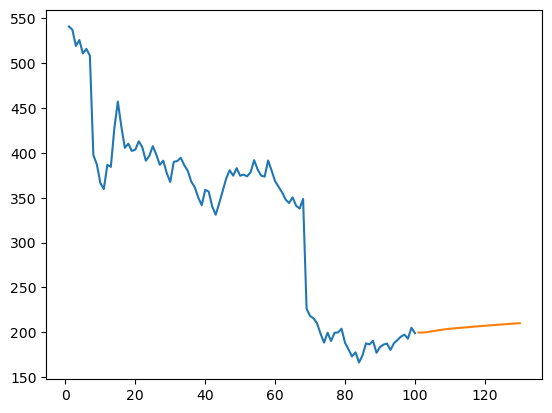

In [35]:
plt.plot(day_new, scaler.inverse_transform(nflx1[4944:]))
plt.plot(day_pred, scaler.inverse_transform(output1));

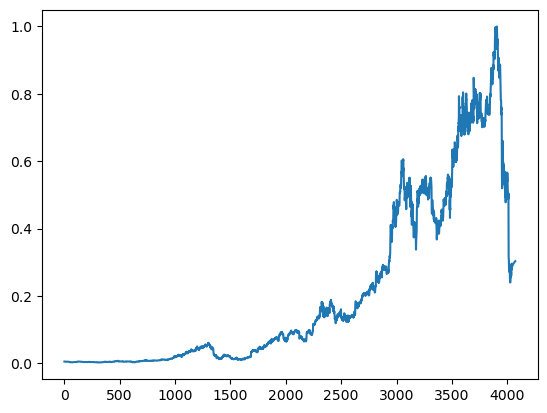

In [36]:
nflx2 = nflx1.tolist()
nflx2.extend(output1)
plt.plot(nflx2[1000:]);

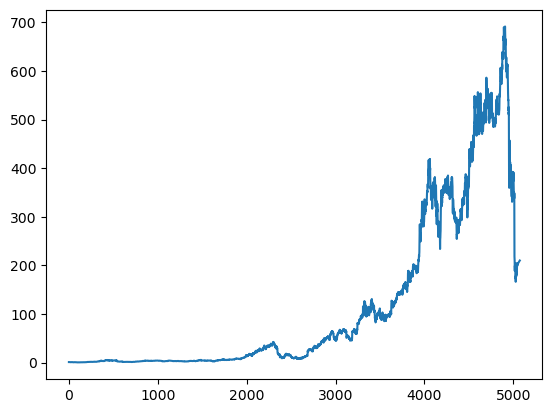

In [37]:
nflx2 = scaler.inverse_transform(nflx2).tolist()
plt.plot(nflx2);

# Thankyou